## Scaling with LO

In this notebook, we consider the simulation of a period chain of qubits. Due to the periodic nature of this problem, for most practical purposes, it requires a 2-qubit operation between two ends of the hardware topology -- which leads to a significant number of SWAP gates. In this notebook we show the usage of gate cutting to deal with such a problem. In summary, we cut the periodic 2-qubit gate, thus removing the necessity of having many SWAP gates. However, this leads to an increase in the number of circuits which needs to be executed (arising from the samples for cutting). The final aim is to show how far this cutting method is useful, and practical, and the improvement it offers in the presence of different error mitigation strategies. 

#### MVP0

In this notebook with show the effect of cutting a single periodic chain of an MBL type circuit and show the improvement it offers without any error mitigation or suppresion techniques.

### Select backend and initial layout

For now the initial layout is handpicked. It may be replaced by mapomatic or anything else in the future.

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
service = QiskitRuntimeService()

In [2]:
backend = service.get_backend('ibm_peekskill')

In [3]:
#init_layout = [0,14,18,19,20,33,39,40,41,53,60,59,58,71,77,78,79,91,98,99,100,110,118,119] # pinguino
#init_layout = [0,1,4,7,10,12,13,14,16,19,22,25] # auckland
#init_layout = [0,1,2,3,4,15,22,21,20,33,39,40,41,53,60,61,62,72,81,82,83,92,102,101,100,110,118,119,120,121,122,123,124,125,126,112]
init_layout = [1,2,3,5,8,11,14,16,19,22,25,26] # peekskill
num_qubits = len(init_layout)
num_qubits

12

### Create the circuit

For this study we consider an MBL-like periodic chain. This is exactly the MBL circuit with a periodic 2-qubit operation connecting the last qubit to the first one. We also use the compute-uncompute variant of it, since for such a circuit the ideal outcome is known without simulation. Note that a depth k (must be even) MBL-like periodic chain requires k/2 gate cuts. However, when we use the compute-uncompute version, it doubles the number of cuts.

TODO: How to avoid unnecessarily increasing the number of cuts? Cliffordization? But that may result in the ideal expectation value going down to 0 for most of the scenarions.

In [4]:
from circuits import *

In [5]:
depth = 2 # depth should be an even number to complete 1 floquet cycle

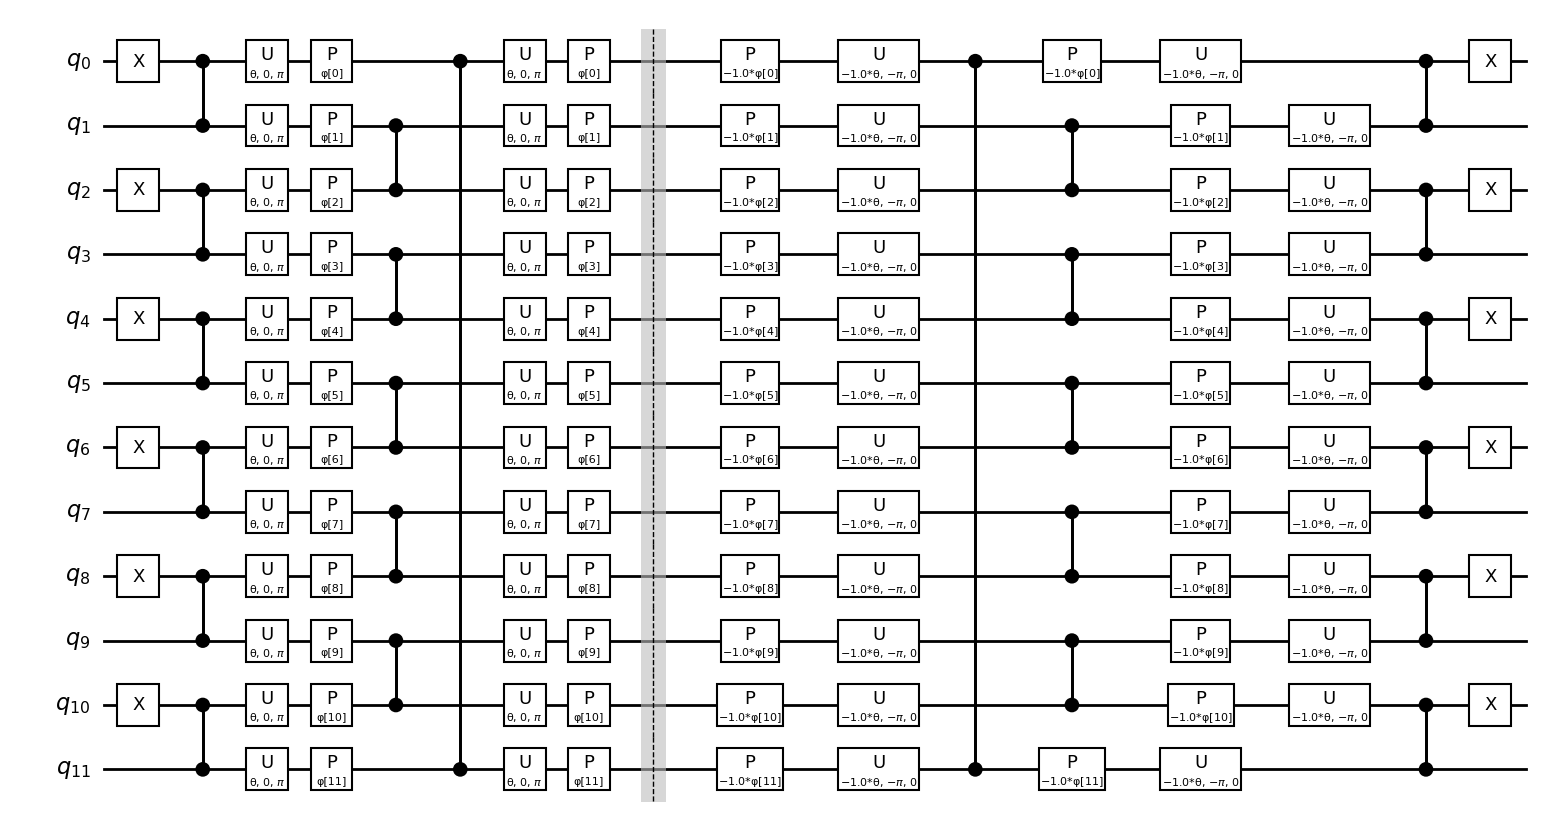

In [6]:
qc = build_compute_uncompute_mbl_circuit(num_qubits, depth, measurements=False)
qc.draw('mpl', style='bw', fold=-1)

We keep track of the 2-qubit depth of the original circuit

In [7]:
qc.depth(lambda x: x[0].num_qubits == 2)

4

We now create parameters randomly, and assign them to the circuit.

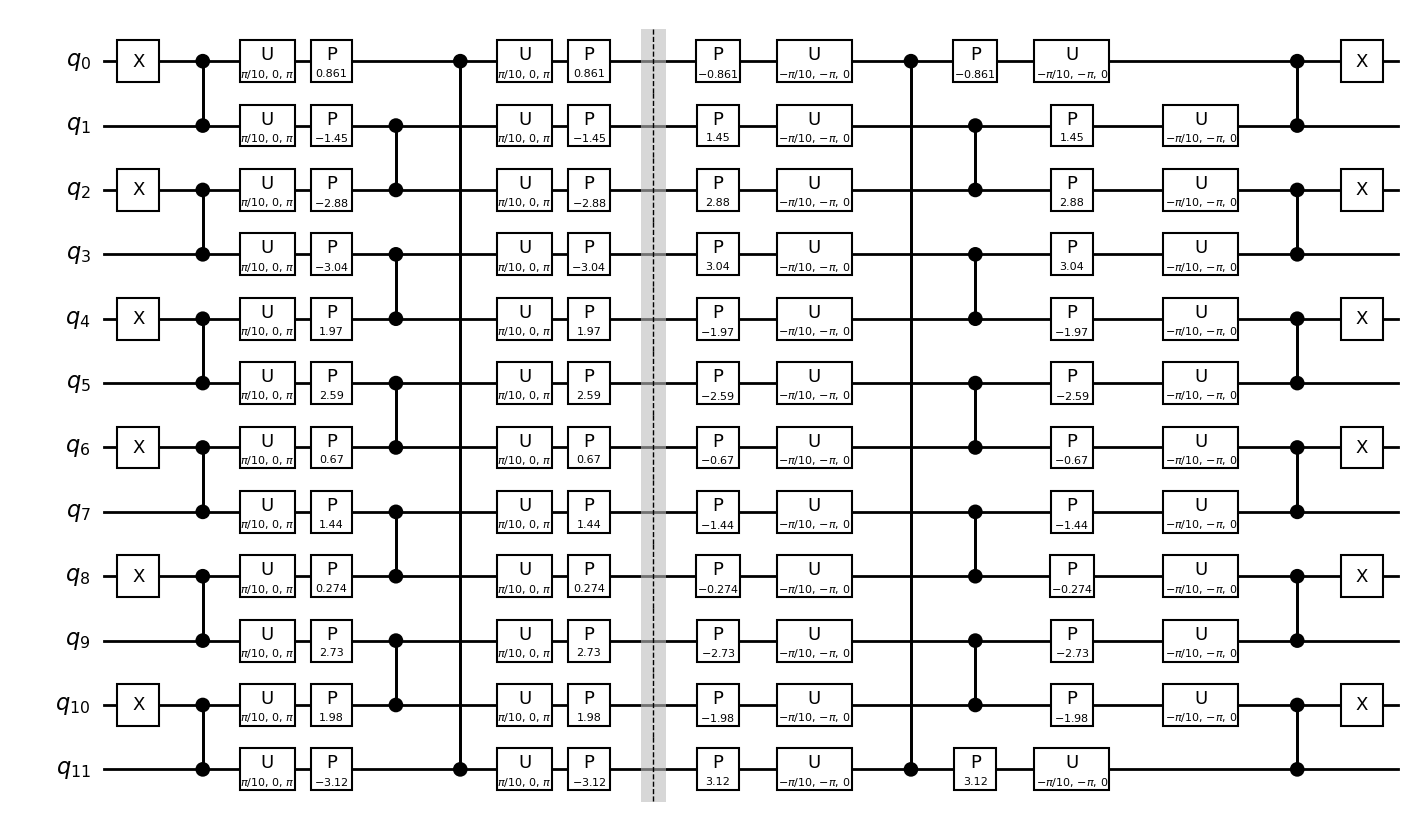

In [8]:
params = produce_mbl_parameters(0.1,num_qubits,seed=0)
theta = params[0]
phis = params[1]

parameters = [theta]
parameters.extend(phis)
#parameters

qc.assign_parameters(parameters, inplace=True)
qc.draw('mpl', style='bw', fold=-1)

### Decide on the observable

We select both weight-1 and nearest neighbour weight-2 observables for this problem. The goal will be to compare the expectation values of the average of weight-1 and weight-2 observables separately.

In [9]:
observables = []

for i in range(num_qubits):
    obs = 'I'*(i)+'Z'+'I'*(num_qubits-i-1)
    observables.append(obs)

for i in range(num_qubits):
    if i == num_qubits-1:
        obs = 'Z'+'I'*(num_qubits-2) + 'Z'
    else:
        obs = 'I'*i+'ZZ'+'I'*(num_qubits-i-2)
    observables.append(obs)

### Transpile the circuit

Now we transpile the original circuit to the backend

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

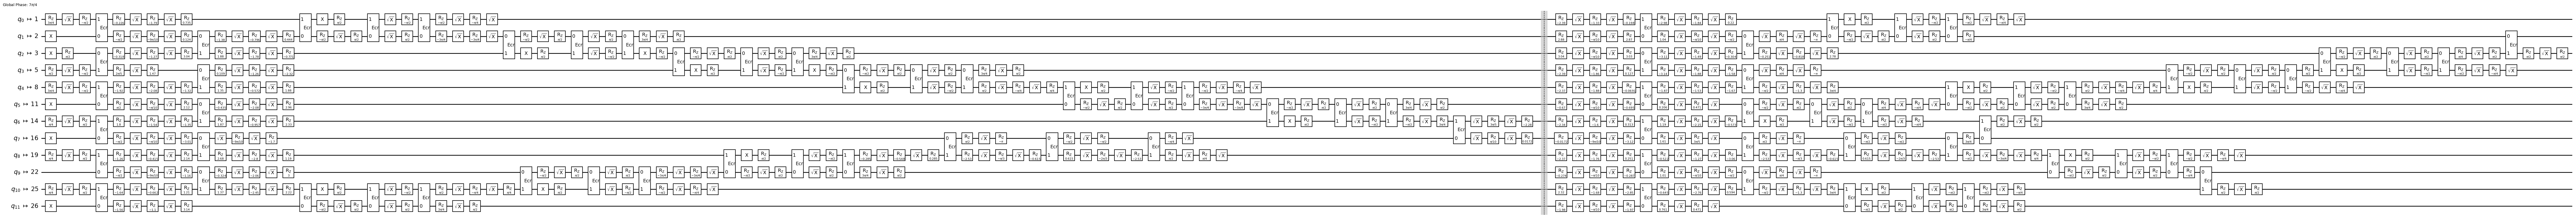

In [11]:
pm = generate_preset_pass_manager(3, backend=backend, initial_layout=init_layout)

trans_qc = pm.run(qc)
trans_qc.draw('mpl', style='bw', fold=-1, idle_wires=False)

We now check the 2-qubit depth of the circuit. Note that the MBL-like circuit was mostly a linear chain except the final periodic 2-qubit operation. Therefore, the increase in depth is due to the insertion of extra SWAP operations in order to facilitate this periodic operation.

In [12]:
trans_qc.depth(lambda x:x[0].num_qubits == 2)

35

### Execute the circuit

Now we shall execute the uncut circuit on the backend and calculate the average of weight-1 and weight-2 observables separately.

First we need to map the observables to the underlying layout.

In [13]:
from qiskit.quantum_info import SparsePauliOp, PauliList

In [14]:
obs_layout_1q = SparsePauliOp(observables[:num_qubits],coeffs=[1/len(observables[:num_qubits])]*len(observables[:num_qubits])).apply_layout(init_layout, num_qubits=backend.num_qubits)
obs_layout_2q = SparsePauliOp(observables[num_qubits:],coeffs=[1/len(observables[num_qubits:])]*len(observables[num_qubits:])).apply_layout(init_layout, num_qubits=backend.num_qubits)

For this example, we shall not use any error mitigation techniques, and hence the resilience level is set to 0.

In [15]:
options = Options()
options.resilience_level=0
options.execution.shots = 10000
options.transpilation.skip_transpilation = True

sampler = Sampler(backend=backend, options=options)

In [16]:
if trans_qc.num_clbits == 0:
    trans_qc.measure_all()

uncut_job = sampler.run(trans_qc)

In [17]:
uncut_result = uncut_job.result().quasi_dists[0].binary_probabilities()

We can now calculate the expectation values for the weight-1 and weight-2 observables

In [18]:
from qiskit.result import sampled_expectation_value

weight_1_expval = sampled_expectation_value(uncut_result, obs_layout_1q)
weight_2_expval = sampled_expectation_value(uncut_result, obs_layout_2q)

In [19]:
print(f'Average of weight-1 expectation values is {weight_1_expval}')
print(f'Average of weight-2 expectation values is {weight_2_expval}')

Average of weight-1 expectation values is 0.15088333333333112
Average of weight-2 expectation values is -0.04489999999999967


### Use circuit (gate) cutting

Now we use gate cutting to remove the periodic 2-qubit gate which is leading to a large number of SWAPs. Note that cutting a gate leads to multiple subcircuits. Therefore, it is reasonable to transpile the uncut circuit once, so that all the subcircuits are transpiled. This saves the time to unnecessarily transpile a large number of circuits.

The primary issue to this approach is that transpiling the uncut circuit leads to a large number of SWAP operations. Therefore, we create a virtual coupling map, where we add an extra connection to account for the periodicity. This ensures that the extra SWAPs can be avoided, and yet the circuit is transpiled correctly.

In [20]:
coupling_map = backend.configuration().coupling_map

virtual_coupling_map = coupling_map.copy()
virtual_coupling_map.append([init_layout[-1],init_layout[0]])
virtual_coupling_map.append([init_layout[0],init_layout[-1]])

In [21]:
pm_virtual = generate_preset_pass_manager(3, coupling_map=virtual_coupling_map, initial_layout=init_layout, basis_gates=backend.configuration().basis_gates)

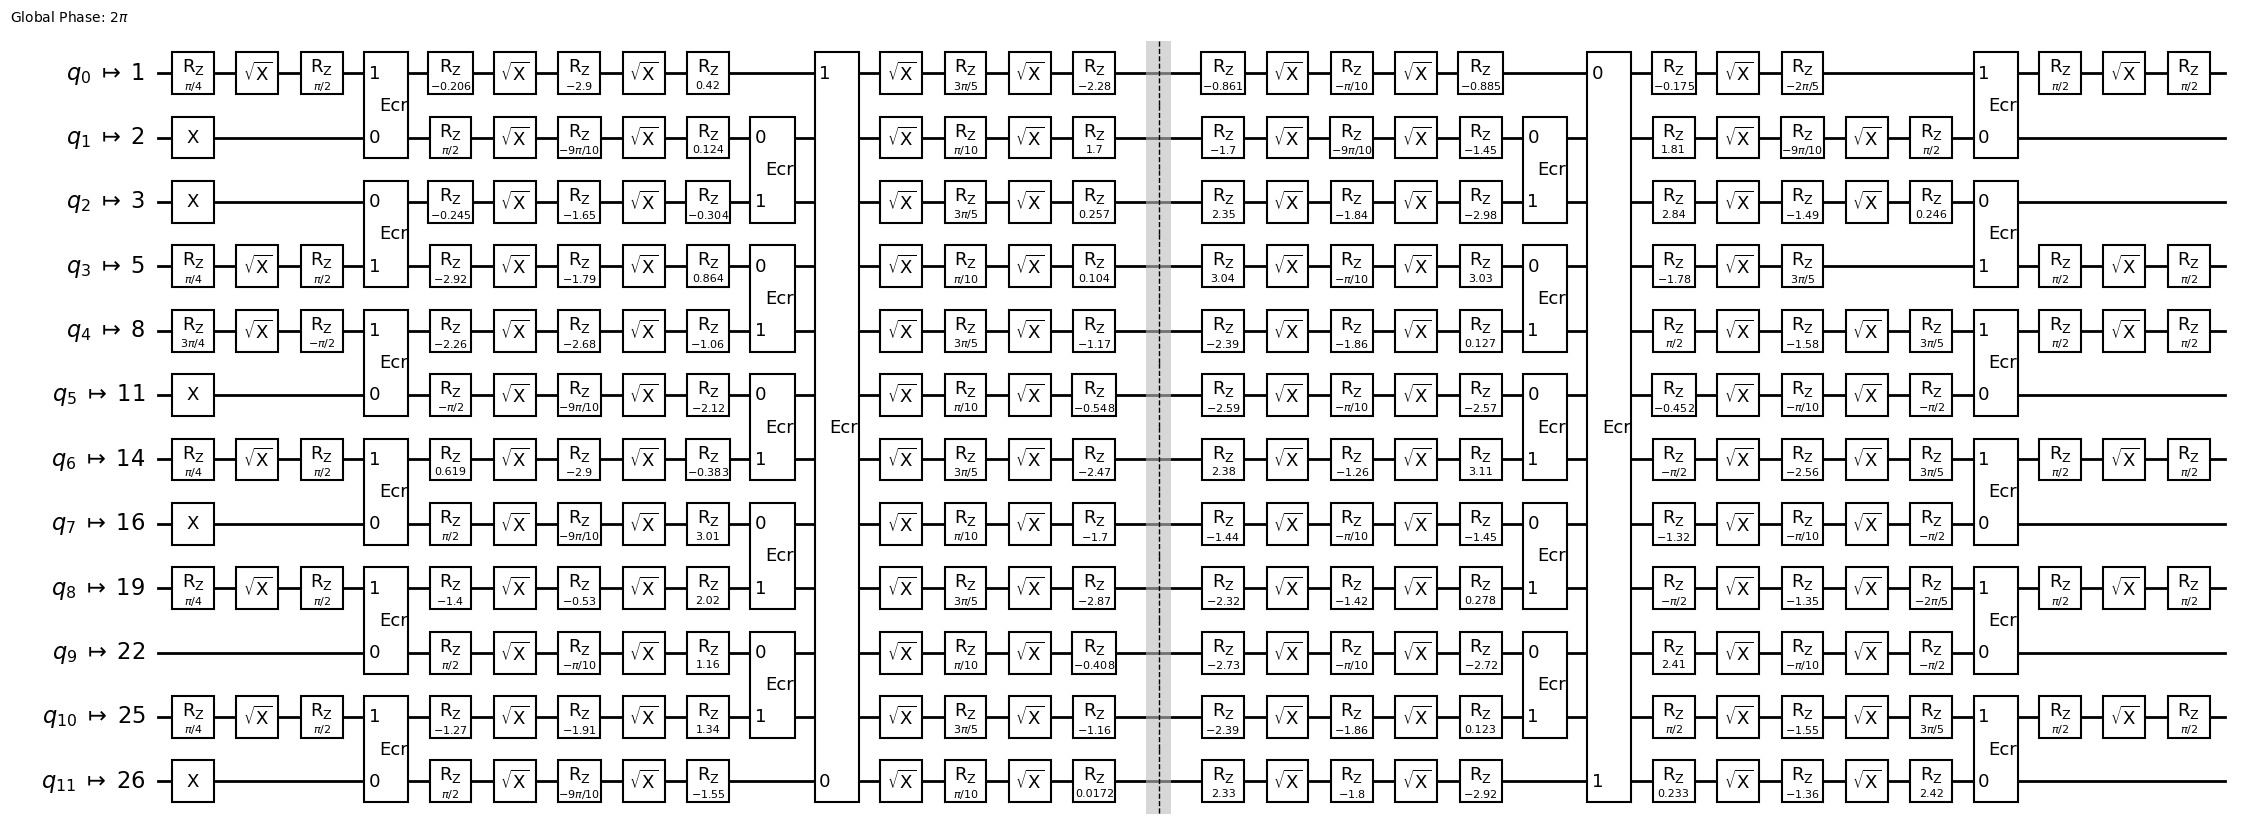

In [22]:
qc_trans = pm_virtual.run(qc)
qc_trans.draw('mpl', style='bw', fold=-1, idle_wires=False)

Note that the depth of the circuit has not increased.

In [23]:
qc_trans.depth(lambda x:x[0].num_qubits == 2)

4

Circuit-knitting-toolbox requires the observables to be in the form of a PauliList. Therefore, we shall first apply the layout to the observables, to make it amenable to the transpilation, and then convert it to PauliList data structure. This will provide the expectation value for each observable separately, and the average needs to be performed as a postprocessing step.

In [24]:
obs = SparsePauliOp(observables).apply_layout(init_layout, num_qubits=backend.num_qubits)
paulis = obs.paulis

Now we cut the circuit based on the index

In [40]:
from circuit_knitting.cutting import cut_gates, generate_cutting_experiments

num_qubits = len(init_layout)

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(qc_trans.data)
    if {qc_trans.find_bit(q)[0] for q in instruction.qubits} == {init_layout[-1],init_layout[0]}
]

In [44]:
import numpy as np

qpd_circuit, bases = cut_gates(qc_trans, cut_indices)
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=paulis, num_samples=np.inf
)

At this point, the subexperiments contains circuits with some 1-qubit gates which are not in the basis gate set. Instead of transpiling them once more, we can use BasisTranslator and then Optimize1qGatesDecomposition to ensure that the circuits are properly transpiled.

In [46]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator, Optimize1qGatesDecomposition

In [47]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
from qiskit.converters import circuit_to_dag, dag_to_circuit

In [48]:
pass_ = PassManager(
    [
        Optimize1qGatesDecomposition(basis=backend.configuration().basis_gates)
    ]
)

In [50]:
subexperiments = pass_.run([dag_to_circuit(
            BasisTranslator(sel, target_basis=backend.basis_gates).run(
                circuit_to_dag(circ)
            )
        )
        for circ in subexperiments])

### Execute the cut circuits and calculate expectation values

In [52]:
sampler = Sampler(backend=backend, options=options)

# Retrieve results from each subexperiment
results = sampler.run(subexperiments).result()

/var/folders/29/5g097jln3fx21kr9g9vfc4540000gn/T/ipykernel_39627/67602806.py:4: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  results = sampler.run(subexperiments).result()


In [53]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    paulis,
)

In [55]:
print(f'Average of weight-1 expectation values is {np.mean(reconstructed_expvals[:num_qubits])}')
print(f'Average of weight-2 expectation values is {np.mean(reconstructed_expvals[num_qubits:])}')

Average of weight-1 expectation values is 0.8809541666666645
Average of weight-2 expectation values is 0.7865416666666656
